# 1: Setting up Python

## 1.1: Package requirements

In [ ]:
!pip install tqdm
!pip install transformers datasets
!pip install torchinfo

In [ ]:
import matplotlib.pyplot as plt   # plotting
import numpy as np                # linear algebra
import pandas as pd               # data processing, CSV file I/O (e.g. pd.read_csv)
import os                         # accessing directory structure
import pickle                     # reading pickle files format
from google.colab import drive    # google drive conection
import seaborn as sns             # graph bar

In [ ]:
import torch
from datasets import Array3D, ClassLabel, Features, load_dataset
from torchinfo import summary
from transformers import AdamW, ViTFeatureExtractor, ViTModel
import tensorflow as tf

## 1.2: Defyning path

In [ ]:
# Monuting google drive - it request permission
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Alexandre's drive Path 
Alex_path = "/content/drive/MyDrive/00-desorganizado/Dataset"

# Leandro path work
Le_path   = "/content/drive/MyDrive/01-projetos_colab/03-PHd/01-Covid_lung_deep"

## 1.3: Creating all folders of the project for outputs

In [ ]:
help(os.mkdir)

Help on built-in function mkdir in module posix:

mkdir(path, mode=511, *, dir_fd=None)
    Create a directory.
    
    If dir_fd is not None, it should be a file descriptor open to a directory,
      and path should be relative; path will then be relative to that directory.
    dir_fd may not be implemented on your platform.
      If it is unavailable, using it will raise a NotImplementedError.
    
    The mode argument is ignored on Windows.



In [ ]:
# Foder to save data
try: 
    os.mkdir(Le_path + "/01_data")
    print("Folder created-01_data")
except OSError as error: 
    print("Folder exists-01_data")

# Foder to save graphs and stats
try: 
    os.mkdir(Le_path + "/02_stats")
    print("Folder created-02_stats")
except OSError as error: 
    print("Folder exists-02_stats")
    
# Foder to save models
try: 
    os.mkdir(Le_path + "/03_fitted_models")
    print("Folder created-03_fitted_models")
except OSError as error: 
    print("Folder exists-03_fitted_models")

# Foder to save models
try: 
    os.mkdir(Le_path + "/04_model_evaluation")
    print("Folder created-04_model_evaluation")
except OSError as error: 
    print("Folder exists-04_model_evaluation")

Folder exists-01_data
Folder exists-02_stats
Folder exists-03_fitted_models
Folder exists-04_model_evaluation


# 2: Data import

## 2.1: Allocating bins to set fold

In [ ]:
j=0
lista_diretorios=[]
for i in range(1,11):
  print("Reading "+ str(i))
  with open(Alex_path +'/pickled_X_data_256x256_fold'+str(i)+'.pickle', 'rb') as f:    
      X_data_aux = np.array(pickle.load(f))
  with open(Alex_path +'/pickled_Y_data_fold'+str(i)+'.pickle', 'rb') as f:    
      Y_data_aux = np.array(pickle.load(f))
      N_Y = len(Y_data_aux)
      Y_data_aux= np.append(np.full((N_Y,1), i),Y_data_aux, axis=1)
      
  if j == 0 :
      X_data = X_data_aux
      Y_data = Y_data_aux
  else:
      X_data = np.concatenate((X_data , X_data_aux),axis=0)
      Y_data = np.concatenate((Y_data , Y_data_aux),axis=0)

  j=j+1

  lista_diretorios= np.append(lista_diretorios ,(Alex_path +'/Bins/Bin'+str(i)))

print('Tamanho base de treino X',len(X_data))
print('Tamanho base de treino Y',len(Y_data))


## 2.2: Dataframe associated to img

In [ ]:
# reaading using pandas
all_img_df = pd.read_csv(Le_path + "/01_data"+'/01-lung-dataset-entry.csv')

print('***** Base com todas as imagens *****')
print(all_img_df['class_covid'].value_counts())

all_img_df.sample(3)

***** Base com todas as imagens *****
2:Covid-19     92288
0:Normal       60840
1:Pneumonia    40291
Name: class_covid, dtype: int64


,filename,class_covid,source_data,id_num,n_esima_img,N_images,Bin,Perc_LOI,lung_area,lung_xdelta,lung_ydelta,xmin,xmax,ymin,ymax
45133,NCP_187_1518_0061.png,2:Covid-19,CNCB,NCP_187,NaN,56,2,23.072433,141988,461,308,36,497,94,402
37398,CP_693_3055_0120.png,1:Pneumonia,CNCB,CP_693,NaN,54,10,25.024033,121669,421,289,34,455,106,395
75163,Normal_1682_857_0018.png,0:Normal,CNCB,Normal_1682,NaN,436,2,29.897690,151906,503,302,0,503,101,403


## 2.3: Exporting files

In [ ]:
np.savez(Le_path + "/01_data/Img_X_Y.npz", 
         X_img_numpy = X_data, 
         Y_lab_numpy = Y_data)

## 2.4: Saving space

In [ ]:
# input list
inputList = ['X_data', 'Y_data']

# Removing all the items from the list
inputList.clear()

# 3: Criating a dataset object of images

In [ ]:
# Loading gzip file
npzfile = np.load(Le_path + "/01_data/Img_X_Y.npz")

# Checking files inside zip file
npzfile.files

['X_img_numpy', 'Y_lab_numpy']

In [ ]:
# Reading it position
X = npzfile['X_img_numpy']
Y = npzfile['Y_lab_numpy']
IMG_df = pd.read_csv(Le_path + "/01_data"+'/01-lung-dataset-entry.csv')
print('Tamanho base de treino X',np.shape(X))
print('Tamanho base de treino Y',np.shape(Y))
print('Tamanho base de treino Y',np.shape(IMG_df))

Tamanho base de treino X (193419, 256, 256)
Tamanho base de treino Y (193419, 4)
Tamanho base de treino Y (193419, 15)


In [ ]:
df = pd.DataFrame(Y, columns = ['Fold','Covid','pneumonia','normal'])

In [ ]:
conditions = [
    df['Covid']     == 1,
    df['pneumonia'] == 1,
    df['normal']    == 1]

choices = ['0:Normal','1:Pneumonia','2:Covid-19']
df['class_lung'] = np.select(conditions, choices)

In [ ]:
df.value_counts()

In [ ]:
Y_labels=df.class_lung.to_numpy()

In [ ]:
from PIL import Image
import numpy as np
import cv2

In [ ]:
def imgs_to_dataset_format():
    for i in range(0, 193418):
        yield { 'img': cv2.merge((X[i], X[i], X[i])) , 'label':Y_labels[i], 'fold': df.Fold.to_numpy()[i]} 

In [ ]:
from datasets import Dataset

In [ ]:
lung_dataset = Dataset.from_generator(imgs_to_dataset_format)

/usr/local/lib/python3.8/dist-packages/datasets/builder.py:712: FutureWarning: 'use_auth_token' was deprecated in version 2.7.1 and will be removed in 3.0.0. Pass `use_auth_token` to the initializer/`load_dataset_builder` instead.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Dataset generator downloaded and prepared to /root/.cache/huggingface/datasets/generator/default-9ef9f287e52ba4ca/0.0.0. Subsequent calls will reuse this data.


In [ ]:
lung_dataset

Dataset({
    features: ['img', 'label', 'fold'],
    num_rows: 193418
})

In [ ]:
lung_dataset.save_to_disk(Le_path + '/01_data/data_set_lung')

Saving the dataset (0/178 shards):   0%|          | 0/193418 [00:00<?, ? examples/s]

# 4: Exploratory analisys

## 4.1: Importing data (just as a test)

In [ ]:
# Loading gzip file
npzfile = np.load(Le_path + "/01_data/Img_X_Y.npz")

# Checking files inside zip file
npzfile.files

['X_img_numpy', 'Y_lab_numpy', 'df_pandas']

In [ ]:
# Reading it position
X = npzfile['X_img_numpy']
Y = npzfile['Y_lab_numpy']
IMG_df = pd.read_csv(Le_path + "/01_data"+'/01-lung-dataset-entry.csv')
print('Tamanho base de treino X',np.shape(X))
print('Tamanho base de treino Y',np.shape(Y))
print('Tamanho base de treino Y',np.shape(IMG_df))

Tamanho base de treino X (193419, 256, 256)
Tamanho base de treino Y (193419, 4)
Tamanho base de treino Y (193419, 15)


## 4.2: Tomograph example

In [ ]:
# Example 03: Image visualization
def show_image(image, title='Image', cmap_type='gray'):
  plt.imshow(image, cmap=cmap_type)
  plt.title(title)
  plt.axis('off')
  plt.show()

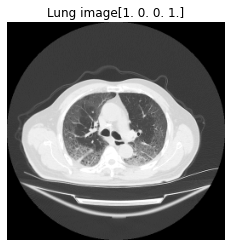

In [ ]:
# Image Grayscale
show_image( X[1],title='Lung image' + str(Y[1]), cmap_type='gray')

## 4.3: data take a look

In [ ]:
IMG_df.sample(5)

,filename,class_covid,source_data,id_num,n_esima_img,N_images,Bin,Perc_LOI,lung_area,lung_xdelta,lung_ydelta,xmin,xmax,ymin,ymax
22838,CP_1606_4294_0013.png,1:Pneumonia,CNCB,CP_1606,13.0,12,6,27.381897,162712,473,344,16,489,74,418
25202,CP_1789_3206_0032.png,1:Pneumonia,CNCB,CP_1789,NaN,136,7,18.362045,128740,410,314,47,457,72,386
98388,Normal_3884_5396_0052.png,0:Normal,CNCB,Normal_3884,NaN,360,7,7.128525,142197,417,341,49,466,41,382
59879,NCP_433_2019_0096.png,2:Covid-19,CNCB,NCP_433,NaN,82,7,12.392044,143284,452,317,37,489,93,410
190045,radiopaedia-40244-42786-0-0041.png,1:Pneumonia,radiopaedia.org,radiopaedia-40244,41.0,41,4,38.264084,262710,630,417,0,630,130,547


## 4.4: Tabulating labels in all data and group (train,val,test)

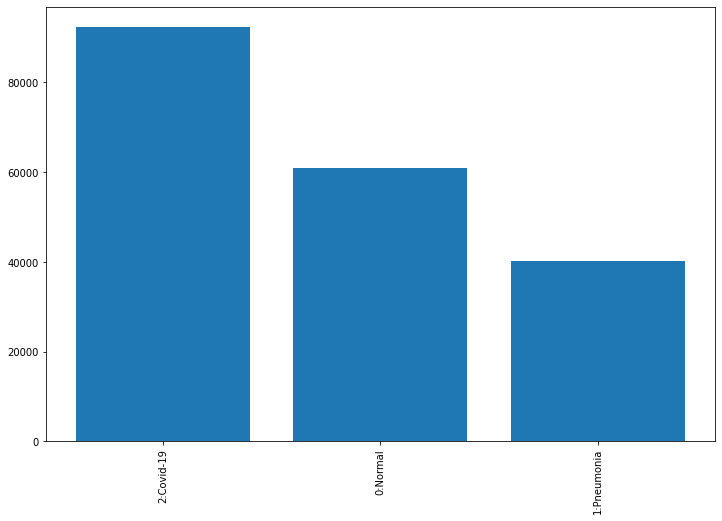

In [ ]:
# Graoh bar
label_counts = IMG_df['class_covid'].value_counts()
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [ ]:
pd.crosstab(IMG_df.class_covid,IMG_df.source_data, margins=True, margins_name="Total")

source_data,CNCB,COVID-CTSet,LIDC-IDRI,SP_Hosp,TCIA,coronacases.org,iCTCF,radiopaedia.org,Total
class_covid,,,,,,,,,
0:Normal,45758,9776,3999,757,0,0,0,550,60840
1:Pneumonia,39009,0,0,0,0,0,0,1282,40291
2:Covid-19,31070,2282,0,2167,7389,1243,45912,2225,92288
Total,115837,12058,3999,2924,7389,1243,45912,4057,193419


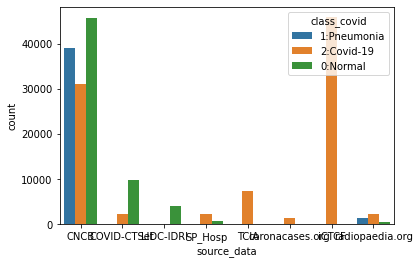

In [ ]:
sns.countplot(x="source_data", hue="class_covid", data=all_img_df)

plt.show()

# 5: [extra] Importing using tensor flow

In [ ]:
io_slices = Alex_path + '/Bin_Slicev3.xlsx'

df_bin_slice=pd.read_excel(io_slices, sheet_name='Geral',usecols = ['filename','patient id','Bin','Bin_Slice','class','Tipo'])

In [ ]:
df_bin_slice['path_bin_file'] = "Bin" + df_bin_slice['Bin'].astype(str) +"/"+ df_bin_slice['filename']

In [ ]:
df_bin_slice.head()

,filename,class,patient id,Bin,Bin_Slice,Tipo,path_bin_file
0,volume-covid19-A-0699-0041.png,2,volume-covid19-A-0699,10,10,COVID-19,Bin10/volume-covid19-A-0699-0041.png
1,volume-covid19-A-0699-0040.png,2,volume-covid19-A-0699,10,10,COVID-19,Bin10/volume-covid19-A-0699-0040.png
2,volume-covid19-A-0699-0026.png,2,volume-covid19-A-0699,10,10,COVID-19,Bin10/volume-covid19-A-0699-0026.png
3,volume-covid19-A-0699-0023.png,2,volume-covid19-A-0699,10,10,COVID-19,Bin10/volume-covid19-A-0699-0023.png
4,volume-covid19-A-0699-0021.png,2,volume-covid19-A-0699,10,10,COVID-19,Bin10/volume-covid19-A-0699-0021.png


In [ ]:
image_size = 224
path_img   = "/content/drive/MyDrive/00-desorganizado/Dataset/Bins"

In [ ]:
import tensorflow as tf

In [ ]:
all_data_import = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [ ]:
 images_iterator = all_data_import.flow_from_dataframe(
    dataframe = df_bin_slice,
    directory = path_img,
    x_col = 'path_bin_file',
    y_col = 'class',
    #y_col = ['class','filename','patient id','Bin','Bin_Slice','Tipo'],
    color_mode="grayscale",
    batch_size=100,
    class_mode=None,
    shuffle=False,
    seed=1,
    target_size = (image_size, image_size)
)

/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:989: UserWarning: Found 9 invalid image filename(s) in x_col="path_bin_file". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '


Found 193410 validated image filenames.


In [ ]:
images_iterator

In [ ]:
first_image = next(images_iterator)

In [ ]:
first_image.shape

(100, 224, 224, 1)